In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import cv2
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions,InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16

In [4]:
train_dir =  r"E:\Workstuff\Deep Learning project\Week 1\train"
val_dir = r"E:\Workstuff\Deep Learning project\Week 1\valid"
test_dir = r"E:\Workstuff\Deep Learning project\Week 1\test"


class_names = sorted(os.listdir(train_dir))
print("Class names:", class_names)

Class names: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL']


In [6]:
img_size=224
batch_size=64

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)


valid_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_size, img_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


As previously seen resnet was not working properly so using different model

In [7]:
model = InceptionV3(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)

# Make all the layers in the pre-trained model non-trainable
for layer in model.layers:
    layer.trainable = False

# Print the model summary
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [10]:
last_layer = model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(20, activation='softmax')(x)           

model = Model(model.input, x) 

model.compile(
    optimizer=RMSprop(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


model.summary()

last layer output shape:  (None, 12, 12, 768)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 122,242,996 (466.32 MB)

 Trainable params: 113,267,732 (432.08 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [12]:
epochs=10

history = model.fit(train_generator, epochs=epochs,batch_size=batch_size, validation_data=valid_generator)

Epoch 1/10


C:\Users\arnav\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4926 - loss: 1.8863 - val_accuracy: 0.9200 - val_loss: 0.4118
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9211 - loss: 0.2478 - val_accuracy: 0.9200 - val_loss: 0.2342
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9688 - loss: 0.1086 - val_accuracy: 0.9300 - val_loss: 0.1676
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9729 - loss: 0.0854 - val_accuracy: 0.9200 - val_loss: 0.2068
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9848 - loss: 0.0712 - val_accuracy: 0.9800 - val_loss: 0.0520
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9900 - loss: 0.0359 - val_accuracy: 0.9800 - val_loss: 0.0590
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9889 - loss: 0.0273 - val_accuracy: 0.9500 - val_loss: 0.0870
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9966 - loss: 0.0157 - val_accuracy: 0.9800 - val_loss: 0.0523
Epo

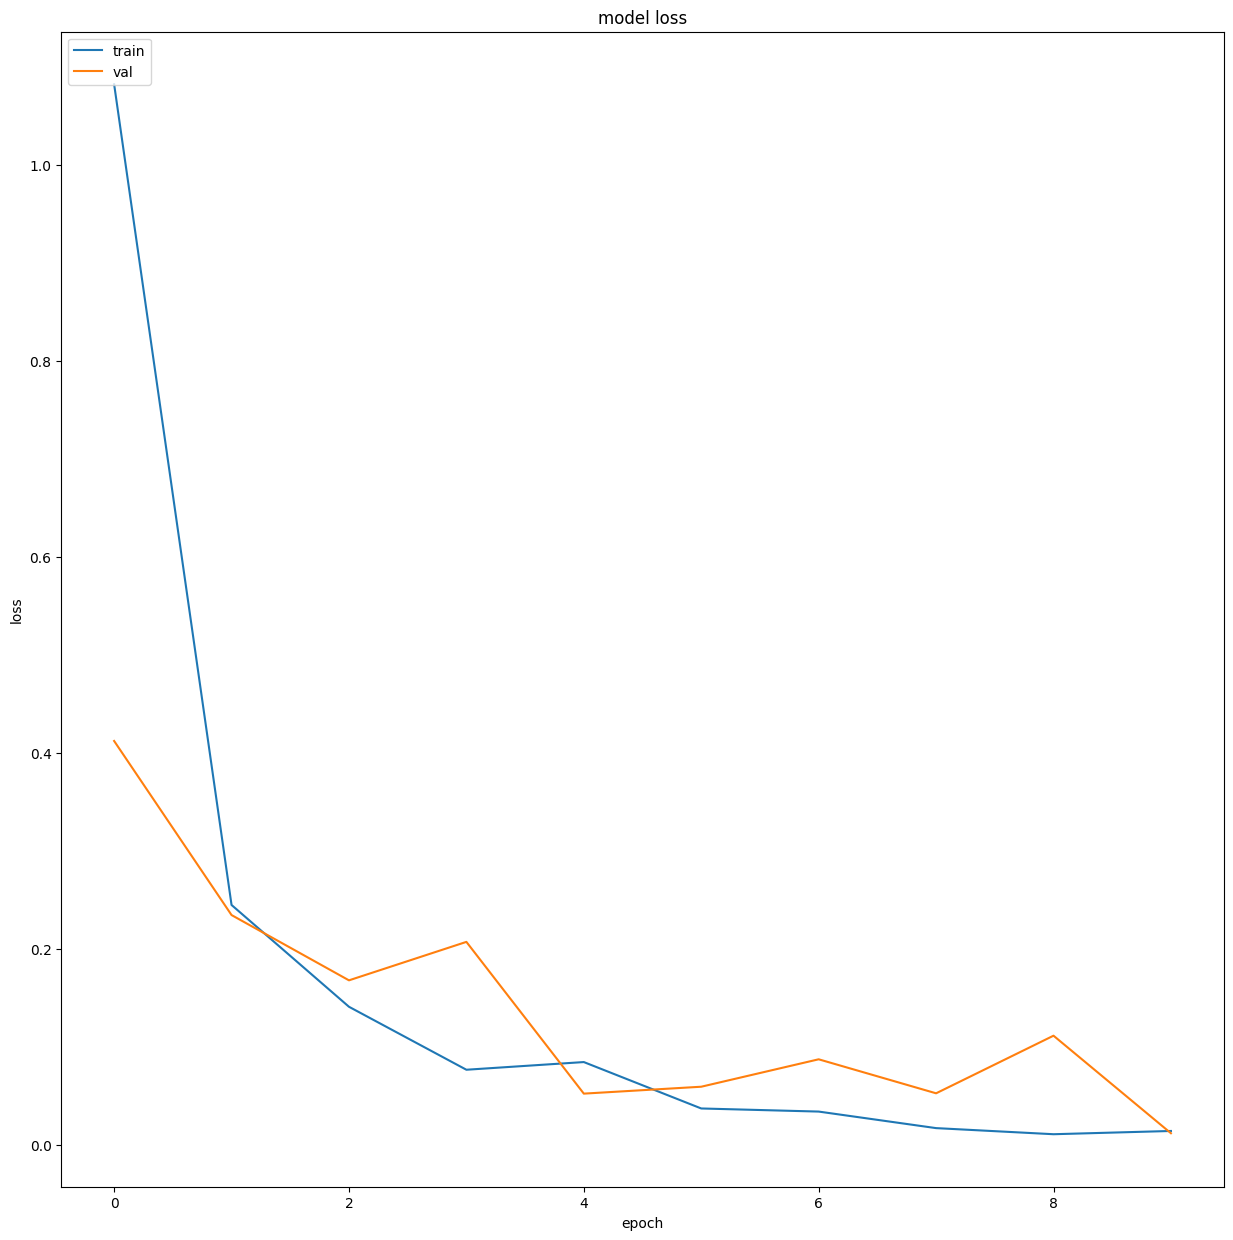

In [13]:
plt.figure(figsize=(15,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Accuracy comes out to be 100% model is overfitting

Trying some most commons techniques to overcome overfitting

In [14]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               verbose=1,
                               mode='max',
                               restore_best_weights=True)

In [15]:
epochs=10

history = model.fit(train_generator, epochs=epochs,batch_size=batch_size, validation_data=valid_generator, callbacks=early_stopping)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9963 - loss: 0.0126 - val_accuracy: 0.9900 - val_loss: 0.0156
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9971 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0188
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9997 - loss: 0.0059 - val_accuracy: 0.9600 - val_loss: 0.0757
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9970 - loss: 0.0091 - val_accuracy: 0.9800 - val_loss: 0.0281
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9941 - loss: 0.0172 - val_accuracy: 0.9900 - val_loss: 0.0228
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9999 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0096
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9900 - val_loss: 0.0151
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


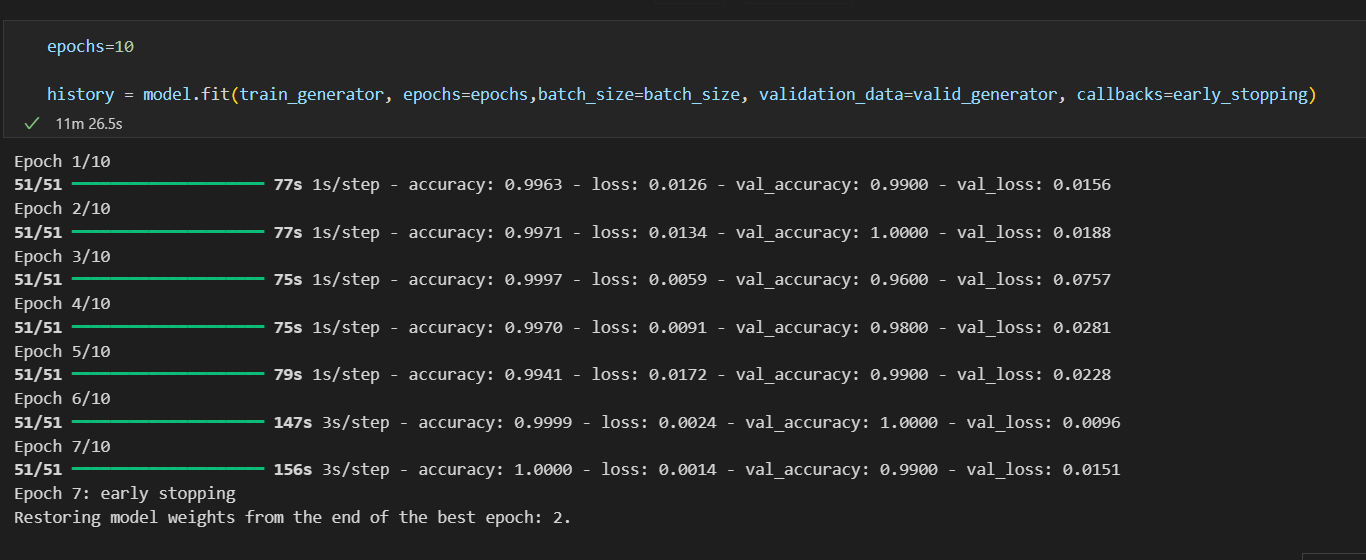

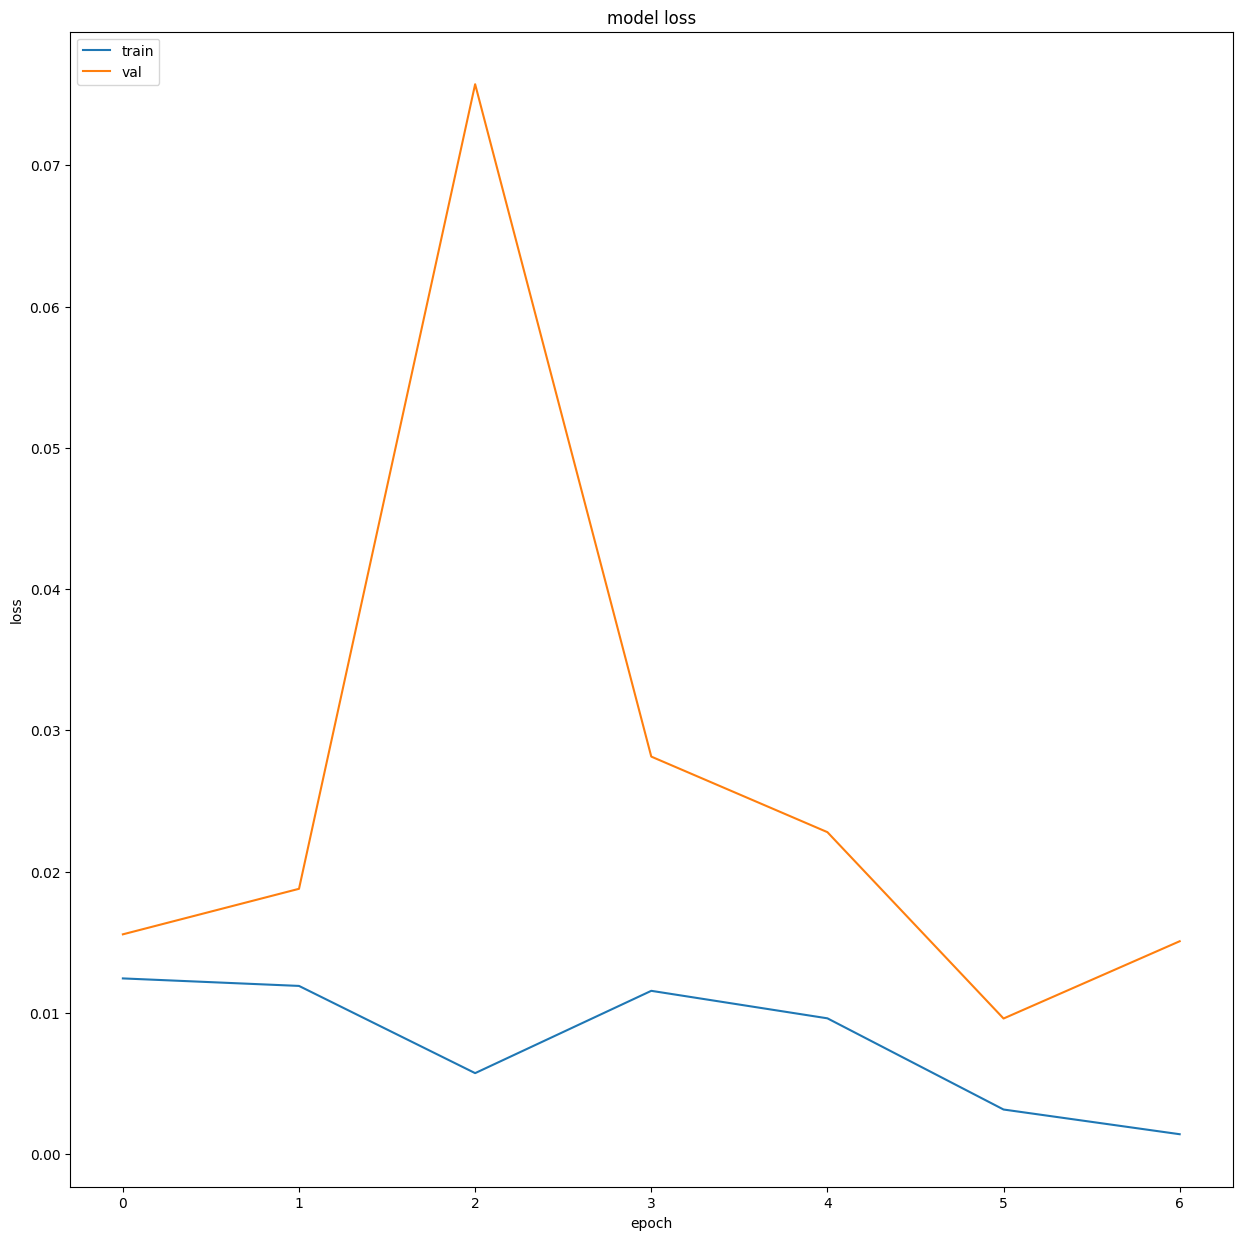

In [16]:
plt.figure(figsize=(15,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()